Загружаем бибилиотеки

In [81]:
import numpy as np
import os
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.metrics

from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Загрузка обработанных данных из первой ДЗ

In [82]:
df = pd.read_csv("fake_job_postprocessing.csv")
df

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,2,4,1,58,22,0
1,0,1,0,1,6,1,75,7,0
2,0,1,0,1,5,1,58,18,0
3,0,1,0,1,5,1,22,31,0
4,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,1,22,31,0
17876,0,1,1,1,5,1,61,0,0
17877,0,0,0,1,5,1,58,18,0
17878,0,0,1,0,6,6,48,9,0


Разбиваю данные на тренировочную и тестовую выборки

In [83]:

y=df['fraudulent']

x=df.drop(['fraudulent'],axis=1)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

N_test, _ = x_test.shape

Обучаем Классификатор

In [84]:
model = MLPClassifier(
    hidden_layer_sizes=(50,),
    solver='adam',
    activation='relu',
    random_state=3,
    max_iter=1000
)

In [85]:
%%time
model.fit(x_train, y_train)

Wall time: 10.2 s


MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=3)

Проверяю качество работы классификатора

In [86]:
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

In [87]:
print('[Accuracy]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy]

Train: 0.9567253914988815, Test: 0.9633668903803132


###### Моя задача достаточно простая, как следствие точность, что на тестовой, что на тренирвоочной, очень большая.

Подбор параметра регуляризации alpha

In [88]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
    test_acc.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

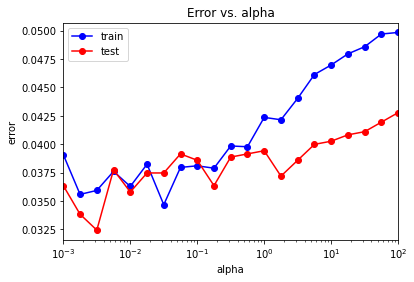

In [89]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

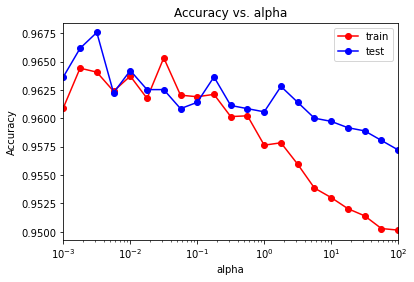

In [90]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

##### Несмотря на то, что разница в точности при азных альфа достаточно мала, мы видим, что при увеличении альфа, точность на тренирвоочной выборке уменьшается(при альфа больше 1). Оптимальным параметром альфа будет [0.00316228]. При таком альфа точность на тестовой и тренировочной выборках совпадает.

Минимальное значение ошибки:

In [91]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.03467561521252797 0.03243847874720358


Альфа

In [92]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.00316228]


Классификатор при оптимальном значении alpha:

In [93]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(50,),
                          solver='adam', activation='relu', random_state=7)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

Точность на обучающей и тестовой выборке:

In [94]:
print('[Accuracy]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy]

Train: 0.9567253914988815, Test: 0.9633668903803132


Матрица рассогласования:

In [95]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[3408  127]
 [  15   26]]


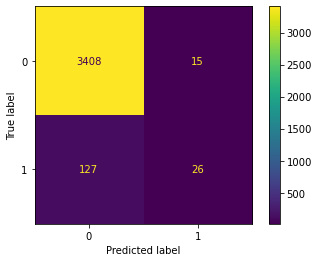

In [96]:
predictions = mlp_model.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()

Подбор числа нейронов

In [97]:
neuron_count_array = np.linspace(10, 300, 30).astype(int)
test_error = []
train_error = []
test_acc = []
train_acc = []

for neuron_count in neuron_count_array:
    model = MLPClassifier(
        alpha=alpha_opt,
        hidden_layer_sizes=(neuron_count,),
        solver='adam',
        activation='relu',
        max_iter=1000,
        random_state=7
    )
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    test_error.append(np.mean(y_test != y_test_pred))
    train_error.append(np.mean(y_train != y_train_pred))
    test_acc.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
    train_acc.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))

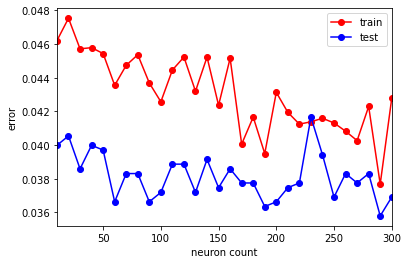

In [98]:
plt.plot(neuron_count_array, train_error, 'r-o', label='train')
plt.plot(neuron_count_array, test_error, 'b-o', label='test')
plt.xlim([np.min(neuron_count_array), np.max(neuron_count_array)])
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

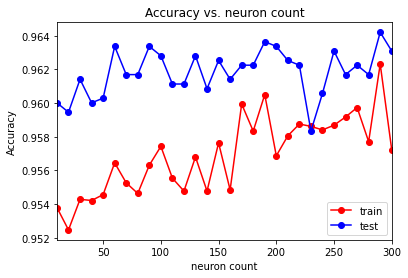

In [99]:
plt.plot(neuron_count_array, train_acc, 'r-o', label='train')
plt.plot(neuron_count_array, test_acc, 'b-o', label='test')
plt.xlim([np.min(neuron_count_array), np.max(neuron_count_array)])
plt.title('Accuracy vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('Accuracy')
plt.legend()

In [100]:
min_test_error = np.min(test_error)
neuron_opt = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_opt))

Optimal neuron count: 290


##### Явную зависимость между количеством нейронов и точностью выделить сложно, но можно отметить, что при заданном диапазоне изучения, с увелечинием числа нейронов, точность на тренирвоочной выборке увеличивалась. Оптипмальное число нейронов 290, в нем была наилучшая точность и на тренировочной и на тестовой выборке.

Классифкатор при найденном значении числа нейронов

In [101]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

Проверка на качества классификатора

In [102]:
print('[Accuracy]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy]

Train: 0.9567253914988815, Test: 0.9633668903803132


###### Примерно такая же точность, что является нормальным для данной задачи.

Подбор оптимального значения параметра регуляризации и числа нейронов

In [103]:
neuron_arr = np.linspace(10, 300, 5).astype(int)
alpha_arr = np.logspace(-3, 2, 5)
test_err = []
train_err = []
train_acc = []
test_acc = []
neuron_alpha_opt = []

for neuron in neuron_arr:
    for alpha in alpha_arr:
        mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(neuron,),
                                  solver='adam', activation='relu', max_iter=1500, random_state=3)
        mlp_model.fit(x_train, y_train)

        y_train_pred = mlp_model.predict(x_train)
        y_test_pred = mlp_model.predict(x_test)

        train_err.append(np.mean(y_train != y_train_pred))
        test_err.append(np.mean(y_test != y_test_pred))
        train_acc.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
        test_acc.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
        neuron_alpha_opt.append([neuron, alpha])

In [104]:
min_test_err = np.min(test_err)
i, = np.where(test_err == min_test_err)
neuron_opt, alpha_opt = neuron_alpha_opt[i[0]]
print("Neuron count opt:", neuron_opt)
print("Alpha opt: ", alpha_opt)

Neuron count opt: 227
Alpha opt:  0.001


Классификатор при найденных оптимальных значениях

In [105]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

Точность на обучающей и тестовой выборке:

In [106]:
print('[Accuracy]\n')
print('Train: {}, Test: {}'.format(
    sklearn.metrics.accuracy_score(y_train, y_train_prediction),
    sklearn.metrics.accuracy_score(y_test, y_test_prediction)
))

[Accuracy]

Train: 0.9567253914988815, Test: 0.9633668903803132


# Выводы

#### Из за высокой точности классификатора без подбора оптимальных параметров. Мой анализ не позволил подобрать такое число нейронов и параметр альфа, которые бы существенно изменили точность классификации.